# SEPP

This is the full-blown, self-excited point process model with non-parametric kernels.

In [1]:
%matplotlib inline
from common import *
datadir = os.path.join("//media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "..", "Data")

GDAL_DATA not set and failed to find suitable location...  This is probably not a problem on linux.


In [2]:
south_side, points = load_data(datadir)

In [3]:
masked_grid = grid_for_south_side()

## Train

In [18]:
import open_cp.sepp as sepp
import importlib
importlib.reload(sepp)

import logging, sys
logger = logging.getLogger("open_cp")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stdout)
logger.addHandler(handler)

In [19]:
trainer = sepp.SEPPTrainer()
trainer.data = points

predictor = trainer.train()

Sample gives (3, 3370) background events and (3, 25) triggered events
Sample gives (3, 3370) background events and (3, 25) triggered events
Completed iteration 0
Completed iteration 0
Sample gives (3, 3328) background events and (3, 67) triggered events
Sample gives (3, 3328) background events and (3, 67) triggered events
Completed iteration 1
Completed iteration 1
Sample gives (3, 3310) background events and (3, 85) triggered events
Sample gives (3, 3310) background events and (3, 85) triggered events
Completed iteration 2
Completed iteration 2
Sample gives (3, 3304) background events and (3, 91) triggered events
Sample gives (3, 3304) background events and (3, 91) triggered events
Completed iteration 3
Completed iteration 3
Sample gives (3, 3297) background events and (3, 98) triggered events
Sample gives (3, 3297) background events and (3, 98) triggered events
Completed iteration 4
Completed iteration 4
Sample gives (3, 3292) background events and (3, 103) triggered events
Sample gi

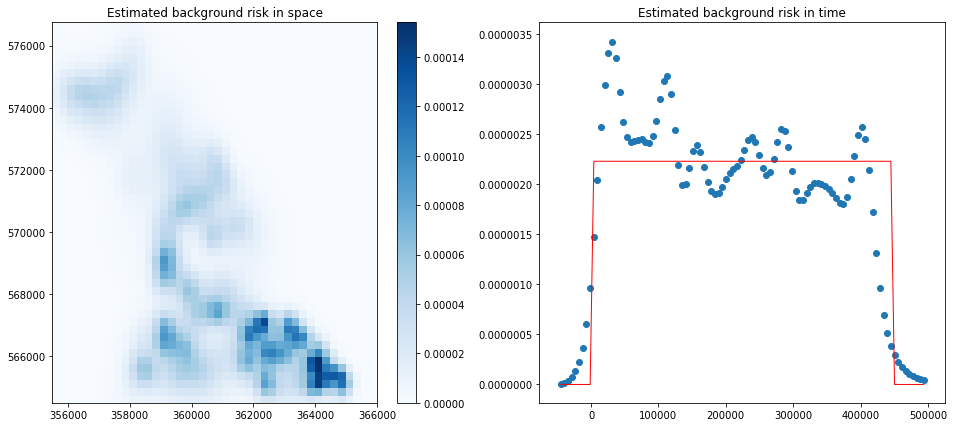

In [27]:
import open_cp.predictors

region = masked_grid.region()
def plot_density(predictor, ax):
    kernel_array = open_cp.predictors.grid_prediction_from_kernel(predictor.background_kernel.space_kernel,
        region, masked_grid.xsize)
    ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
    mesh = ax.pcolormesh(*kernel_array.mesh_data(), kernel_array.intensity_matrix, cmap="Blues")
    fig.colorbar(mesh, ax=ax)
    return kernel_array

fig, ax = plt.subplots(ncols=2, figsize=(16,7))
kernel_array = plot_density(predictor, ax[0])

# Time unit is minutes
total_time = points.time_deltas()[-1]
tc = np.linspace(-total_time * 0.1, total_time * 1.1, 100)
def actual(t):
    return ((t>=0) & (t<=total_time)) / total_time
ax[1].plot(tc, actual(tc), linewidth=1, color="r")
ax[1].scatter(tc, predictor.background_kernel.time_kernel(tc))
ax[0].set_title("Estimated background risk in space")
ax[1].set_title("Estimated background risk in time")
None

In [28]:
# "Stocastically decluster"
backgrounds, aftershocks = sepp.sample_points(trainer.as_time_space_points(), predictor.result.p)

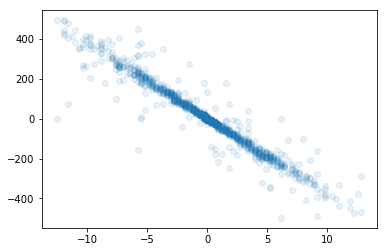

In [40]:
plt.scatter(aftershocks[1], aftershocks[2], alpha=0.1)

(array([ 354.,  250.,  213.,  144.,  149.,  119.,  118.,  100.,   58.,   56.]),
 array([   0.        ,   11.99166667,   23.98333333,   35.975     ,
          47.96666667,   59.95833333,   71.95      ,   83.94166667,
          95.93333333,  107.925     ,  119.91666667]),
 <a list of 10 Patch objects>)

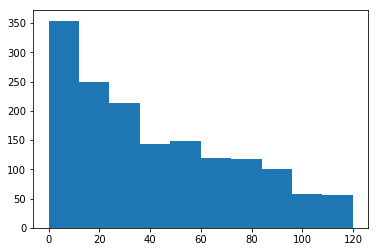

In [34]:
plt.hist(aftershocks[0] / 60 / 24)

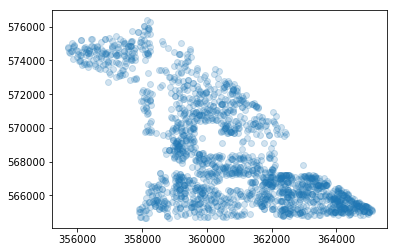

In [36]:
plt.scatter(backgrounds[1], backgrounds[2], alpha=0.2)